In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings('ignore')

# --- 1. 高级配置 ---
class Config:
    GPU_ID = 3
    SEED = 2025
    
    # 路径
    DATA_PATH_PREFIX = 'data/Unet/'
    TRAIN_IMG = os.path.join(DATA_PATH_PREFIX, 'train-volume.tif')
    TRAIN_LBL = os.path.join(DATA_PATH_PREFIX, 'train-labels.tif')
    TEST_IMG = os.path.join(DATA_PATH_PREFIX, 'test-volume.tif')
    SAVE_PATH = 'best_sota_model.pth'
    
    # 训练超参数
    IMG_SIZE = 512 # 可以在这里调整输入尺寸
    BATCH_SIZE = 4
    EPOCHS = 80
    LR = 1e-3
    MIN_LR = 1e-6
    WEIGHT_DECAY = 1e-4
    PATIENCE = 15 # 早停耐心值
    
    # 损失函数参数 (Tversky)
    ALPHA = 0.7 # 惩罚假阴性 (False Negative) 的权重, 召回率优先
    BETA = 0.3
    GAMMA = 0.75 # Focal参数

# --- 2. 硬件设置 ---
os.environ["CUDA_VISIBLE_DEVICES"] = str(Config.GPU_ID)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True # 开启benchmark加速

set_seed(Config.SEED)
print(f"Running on Device: {DEVICE}")

Running on Device: cuda


In [3]:
# --- 实现弹性形变 (Elastic Deformation) ---
# 这是医学图像分割中最重要的增强手段之一
def elastic_transform(image, alpha, sigma, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = cv2.GaussianBlur((random_state.rand(*shape) * 2 - 1), (0, 0), sigma) * alpha
    dy = cv2.GaussianBlur((random_state.rand(*shape) * 2 - 1), (0, 0), sigma) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    map_x = np.float32(x + dx)
    map_y = np.float32(y + dy)

    return cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

class AdvancedISBIDataset(Dataset):
    def __init__(self, images, labels, augment=False):
        self.images = images
        self.labels = labels
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # 转换为 Numpy float32 [0, 1]
        img = self.images[idx].astype(np.float32) / 255.0
        mask = self.labels[idx].astype(np.float32) / 255.0 # 暂时保持0-1 float用于处理
        
        if self.augment:
            # 1. 弹性形变 (最关键的增强)
            if random.random() < 0.5:
                # 生成相同的随机种子以保证img和mask同步形变
                seed = np.random.randint(1, 10000)
                rs = np.random.RandomState(seed)
                img = elastic_transform(img, alpha=img.shape[1] * 2, sigma=img.shape[1] * 0.08, random_state=rs)
                rs = np.random.RandomState(seed)
                mask = elastic_transform(mask, alpha=mask.shape[1] * 2, sigma=mask.shape[1] * 0.08, random_state=rs)

            # 转回 PIL 用于 torchvision transforms
            img_pil = Image.fromarray((img * 255).astype(np.uint8))
            mask_pil = Image.fromarray((mask * 255).astype(np.uint8))

            # 2. 随机旋转与翻转
            if random.random() > 0.5:
                angle = random.randint(-45, 45)
                img_pil = TF.rotate(img_pil, angle)
                mask_pil = TF.rotate(mask_pil, angle)
            
            if random.random() > 0.5:
                img_pil = TF.hflip(img_pil)
                mask_pil = TF.hflip(mask_pil)
                
            if random.random() > 0.5:
                img_pil = TF.vflip(img_pil)
                mask_pil = TF.vflip(mask_pil)
            
            # 3. 仿射变换 (已修复 Bug)
            if random.random() > 0.5:
                # 修改点：degrees=0 改为 degrees=(0, 0)
                params = transforms.RandomAffine.get_params(
                    degrees=(0, 0), 
                    translate=(0.1, 0.1), 
                    scale_ranges=(0.8, 1.2), 
                    shears=(-10, 10), 
                    img_size=img_pil.size
                )
                img_pil = TF.affine(img_pil, *params)
                mask_pil = TF.affine(mask_pil, *params)

            # 4. 颜色增强 (仅对原图)
            if random.random() > 0.5:
                img_pil = TF.adjust_contrast(img_pil, random.uniform(0.7, 1.3))
                img_pil = TF.adjust_brightness(img_pil, random.uniform(0.7, 1.3))
                img_pil = TF.adjust_gamma(img_pil, random.uniform(0.7, 1.5))
            
            # 转 Tensor
            img_t = TF.to_tensor(img_pil)
            mask_t = torch.from_numpy(np.array(mask_pil)).long().unsqueeze(0)
            mask_t[mask_t > 0] = 1 # 二值化
            
        else:
            # 验证集处理
            img_t = torch.from_numpy(img).unsqueeze(0)
            mask_t = torch.from_numpy(mask).long().unsqueeze(0)
            mask_t[mask_t > 0.5] = 1

        return img_t, mask_t.squeeze(0)

# 加载数据函数
def load_tiff(path):
    return np.array([np.array(p) for p in ImageSequence.Iterator(Image.open(path))])

print("Advanced Augmentation Pipeline Ready (Fixed).")

Advanced Augmentation Pipeline Ready (Fixed).


In [4]:
# --- 1. Residual Block (残差块) ---
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c)
        )
        self.relu = nn.ReLU(inplace=True)
        # 如果输入输出通道不一致，通过1x1卷积调整
        self.shortcut = nn.Sequential()
        if in_c != out_c:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_c, out_c, 1, bias=False),
                nn.BatchNorm2d(out_c)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv(x)
        out += residual
        out = self.relu(out)
        return out

# --- 2. Attention Block (注意力门) ---
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

# --- 3. ASPP (Atrous Spatial Pyramid Pooling) ---
# 用于捕获多尺度上下文
class ASPP(nn.Module):
    def __init__(self, in_dims, out_dims, rate=[6, 12, 18]):
        super(ASPP, self).__init__()
        self.aspp_blocks = nn.ModuleList()
        # 1x1 Conv
        self.aspp_blocks.append(nn.Sequential(
            nn.Conv2d(in_dims, out_dims, 1, bias=False), nn.BatchNorm2d(out_dims), nn.ReLU(inplace=True)))
        # 3x3 Conv with rates
        for r in rate:
            self.aspp_blocks.append(nn.Sequential(
                nn.Conv2d(in_dims, out_dims, 3, stride=1, padding=r, dilation=r, bias=False),
                nn.BatchNorm2d(out_dims), nn.ReLU(inplace=True)))
        # Global Pooling
        self.global_avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(in_dims, out_dims, 1, bias=False),
            nn.BatchNorm2d(out_dims), nn.ReLU(inplace=True))
        
        self.output_conv = nn.Sequential(
            nn.Conv2d(out_dims * (len(rate) + 2), out_dims, 1, bias=False),
            nn.BatchNorm2d(out_dims), nn.ReLU(inplace=True))

    def forward(self, x):
        out = []
        for block in self.aspp_blocks:
            out.append(block(x))
        out.append(F.interpolate(self.global_avg_pool(x), size=x.shape[2:], mode='bilinear', align_corners=True))
        out = torch.cat(out, dim=1)
        return self.output_conv(out)

In [5]:
class ResAttUnetASPP(nn.Module):
    def __init__(self, n_channels=1, n_classes=2):
        super().__init__()
        
        # Encoder (ResBlocks)
        self.inc = ResidualBlock(n_channels, 32)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), ResidualBlock(32, 64))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), ResidualBlock(64, 128))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), ResidualBlock(128, 256))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), ResidualBlock(256, 512))
        
        # Bridge (ASPP)
        self.aspp = ASPP(512, 512)
        
        # Decoder (Attention + UpSampling + ResBlocks)
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att1 = AttentionBlock(F_g=512, F_l=256, F_int=128)
        self.conv_up1 = ResidualBlock(512+256, 256)
        
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att2 = AttentionBlock(F_g=256, F_l=128, F_int=64)
        self.conv_up2 = ResidualBlock(256+128, 128)
        
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att3 = AttentionBlock(F_g=128, F_l=64, F_int=32)
        self.conv_up3 = ResidualBlock(128+64, 64)
        
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.att4 = AttentionBlock(F_g=64, F_l=32, F_int=16)
        self.conv_up4 = ResidualBlock(64+32, 32)
        
        self.outc = nn.Conv2d(32, n_classes, 1)
        
    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Bridge with ASPP
        x_aspp = self.aspp(x5)
        
        # Decoder with Attention
        u1 = self.up1(x_aspp)
        # Handle Padding if needed (omitted for cleaner code assuming power of 2 size)
        x4_att = self.att1(g=u1, x=x4)
        u1 = torch.cat([x4_att, u1], dim=1)
        u1 = self.conv_up1(u1)
        
        u2 = self.up2(u1)
        x3_att = self.att2(g=u2, x=x3)
        u2 = torch.cat([x3_att, u2], dim=1)
        u2 = self.conv_up2(u2)
        
        u3 = self.up3(u2)
        x2_att = self.att3(g=u3, x=x2)
        u3 = torch.cat([x2_att, u3], dim=1)
        u3 = self.conv_up3(u3)
        
        u4 = self.up4(u3)
        x1_att = self.att4(g=u4, x=x1)
        u4 = torch.cat([x1_att, u4], dim=1)
        u4 = self.conv_up4(u4)
        
        logits = self.outc(u4)
        return logits

print("SOTA Architecture (Res-Attention U-Net + ASPP) initialized.")

SOTA Architecture (Res-Attention U-Net + ASPP) initialized.


In [6]:
class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=Config.ALPHA, beta=Config.BETA, gamma=Config.GAMMA, smooth=1e-6):
        super(FocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        # inputs: logits [B, C, H, W]
        # targets: labels [B, H, W]
        
        inputs = F.softmax(inputs, dim=1)
        
        # One-hot encoding targets
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()
        
        # Focus on class 1 (Foreground)
        inputs = inputs[:, 1]
        targets = targets[:, 1]
        
        # True Positives, False Positives, False Negatives
        TP = (inputs * targets).sum()
        FP = ((1 - targets) * inputs).sum()
        FN = (targets * (1 - inputs)).sum()
        
        # Tversky Index
        Tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        
        # Focal Tversky Loss
        FocalTversky = (1 - Tversky) ** self.gamma
        
        return FocalTversky

# 辅助评估指标
def get_metrics(inputs, targets):
    inputs = torch.argmax(inputs, dim=1)
    # Dice
    intersection = (inputs & targets).float().sum()
    union = (inputs | targets).float().sum()
    dice = (2. * intersection + 1e-6) / (inputs.sum() + targets.sum() + 1e-6)
    # IoU
    iou = (intersection + 1e-6) / (union + 1e-6)
    return dice.item(), iou.item()

In [7]:
# 1. 准备数据
all_images = load_tiff(Config.TRAIN_IMG)
all_labels = load_tiff(Config.TRAIN_LBL)

# 划分
indices = list(range(len(all_images)))
random.shuffle(indices)
split = int(0.2 * len(all_images))
val_idx, train_idx = indices[:split], indices[split:]

train_ds = AdvancedISBIDataset(all_images[train_idx], all_labels[train_idx], augment=True)
val_ds = AdvancedISBIDataset(all_images[val_idx], all_labels[val_idx], augment=False)

train_loader = DataLoader(train_ds, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)

# 2. 初始化对象
model = ResAttUnetASPP(n_channels=1, n_classes=2).to(DEVICE)
criterion = FocalTverskyLoss()

# 3. 优化器：AdamW (权重衰减处理得更好)
optimizer = optim.AdamW(model.parameters(), lr=Config.LR, weight_decay=Config.WEIGHT_DECAY)

# 4. 学习率调度器：余弦退火热重启 (Cosine Annealing Warm Restarts)
# 这会让LR周期性下降和重置，有助于找到更好的全局最优
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=Config.MIN_LR)

print(f"Dataset: Train={len(train_ds)}, Val={len(val_ds)}")

Dataset: Train=24, Val=6


In [8]:
class EarlyStopping:
    def __init__(self, patience=10, path=Config.SAVE_PATH):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased. Saving model...')

# --- 训练 ---
early_stopping = EarlyStopping(patience=Config.PATIENCE)
history = {'train_loss': [], 'val_loss': [], 'val_dice': [], 'val_iou': [], 'lr': []}

print("--- Starting SOTA Training Pipeline ---")

for epoch in range(Config.EPOCHS):
    model.train()
    train_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.EPOCHS}", leave=False)
    
    for imgs, masks in loop:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())
        
    # 验证
    model.eval()
    val_loss = 0
    val_dice = 0
    val_iou = 0
    
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            
            d, i = get_metrics(outputs, masks)
            val_loss += loss.item()
            val_dice += d
            val_iou += i
            
    # 记录
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)
    current_lr = optimizer.param_groups[0]['lr']
    
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_dice'].append(avg_val_dice)
    history['val_iou'].append(avg_val_iou)
    history['lr'].append(current_lr)
    
    print(f"Epoch {epoch+1} | T_Loss: {avg_train_loss:.4f} | V_Loss: {avg_val_loss:.4f} | Dice: {avg_val_dice:.4f} | IoU: {avg_val_iou:.4f} | LR: {current_lr:.2e}")
    
    # 调度器步进
    scheduler.step(epoch + avg_val_loss) # 注意：CosineAnnealingWarmRestarts通常基于epoch更新
    
    # 早停检查
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break


--- Starting SOTA Training Pipeline ---


Epoch 1/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1 | T_Loss: 0.3712 | V_Loss: 0.3610 | Dice: 0.8849 | IoU: 0.7940 | LR: 1.00e-03
Validation loss decreased. Saving model...


Epoch 2/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2 | T_Loss: 0.2450 | V_Loss: 0.3015 | Dice: 0.8850 | IoU: 0.7940 | LR: 9.97e-04
Validation loss decreased. Saving model...


Epoch 3/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3 | T_Loss: 0.2148 | V_Loss: 0.2690 | Dice: 0.8921 | IoU: 0.8054 | LR: 9.59e-04
Validation loss decreased. Saving model...


Epoch 4/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4 | T_Loss: 0.1997 | V_Loss: 0.2627 | Dice: 0.8511 | IoU: 0.7447 | LR: 8.78e-04
Validation loss decreased. Saving model...


Epoch 5/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5 | T_Loss: 0.1952 | V_Loss: 0.2758 | Dice: 0.7944 | IoU: 0.6630 | LR: 7.60e-04
EarlyStopping counter: 1 out of 15


Epoch 6/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6 | T_Loss: 0.1821 | V_Loss: 0.2030 | Dice: 0.8735 | IoU: 0.7768 | LR: 6.13e-04
Validation loss decreased. Saving model...


Epoch 7/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7 | T_Loss: 0.1771 | V_Loss: 0.1736 | Dice: 0.9056 | IoU: 0.8277 | LR: 4.69e-04
Validation loss decreased. Saving model...


Epoch 8/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8 | T_Loss: 0.1715 | V_Loss: 0.1698 | Dice: 0.9063 | IoU: 0.8294 | LR: 3.20e-04
Validation loss decreased. Saving model...


Epoch 9/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9 | T_Loss: 0.1707 | V_Loss: 0.1617 | Dice: 0.9170 | IoU: 0.8471 | LR: 1.86e-04
Validation loss decreased. Saving model...


Epoch 10/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10 | T_Loss: 0.1713 | V_Loss: 0.1616 | Dice: 0.9152 | IoU: 0.8443 | LR: 8.20e-05
Validation loss decreased. Saving model...


Epoch 11/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11 | T_Loss: 0.1717 | V_Loss: 0.1601 | Dice: 0.9171 | IoU: 0.8476 | LR: 1.82e-05
Validation loss decreased. Saving model...


Epoch 12/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12 | T_Loss: 0.1735 | V_Loss: 0.1582 | Dice: 0.9270 | IoU: 0.8642 | LR: 1.00e-03
Validation loss decreased. Saving model...


Epoch 13/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13 | T_Loss: 0.1637 | V_Loss: 0.1592 | Dice: 0.9212 | IoU: 0.8541 | LR: 9.92e-04
EarlyStopping counter: 1 out of 15


Epoch 14/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14 | T_Loss: 0.1750 | V_Loss: 0.1626 | Dice: 0.9023 | IoU: 0.8223 | LR: 9.72e-04
EarlyStopping counter: 2 out of 15


Epoch 15/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15 | T_Loss: 0.1565 | V_Loss: 0.1483 | Dice: 0.9113 | IoU: 0.8376 | LR: 9.40e-04
Validation loss decreased. Saving model...


Epoch 16/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16 | T_Loss: 0.1539 | V_Loss: 0.1399 | Dice: 0.9302 | IoU: 0.8697 | LR: 8.98e-04
Validation loss decreased. Saving model...


Epoch 17/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17 | T_Loss: 0.1523 | V_Loss: 0.1742 | Dice: 0.9071 | IoU: 0.8304 | LR: 8.46e-04
EarlyStopping counter: 1 out of 15


Epoch 18/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18 | T_Loss: 0.1435 | V_Loss: 0.1381 | Dice: 0.9346 | IoU: 0.8777 | LR: 7.83e-04
Validation loss decreased. Saving model...


Epoch 19/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19 | T_Loss: 0.1476 | V_Loss: 0.1302 | Dice: 0.9286 | IoU: 0.8672 | LR: 7.18e-04
Validation loss decreased. Saving model...


Epoch 20/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20 | T_Loss: 0.1443 | V_Loss: 0.1351 | Dice: 0.9317 | IoU: 0.8723 | LR: 6.45e-04
EarlyStopping counter: 1 out of 15


Epoch 21/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 21 | T_Loss: 0.1475 | V_Loss: 0.1265 | Dice: 0.9343 | IoU: 0.8769 | LR: 5.68e-04
Validation loss decreased. Saving model...


Epoch 22/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 22 | T_Loss: 0.1496 | V_Loss: 0.1397 | Dice: 0.9151 | IoU: 0.8439 | LR: 4.91e-04
EarlyStopping counter: 1 out of 15


Epoch 23/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 23 | T_Loss: 0.1586 | V_Loss: 0.1342 | Dice: 0.9340 | IoU: 0.8763 | LR: 4.12e-04
EarlyStopping counter: 2 out of 15


Epoch 24/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 24 | T_Loss: 0.1430 | V_Loss: 0.1348 | Dice: 0.9363 | IoU: 0.8804 | LR: 3.36e-04
EarlyStopping counter: 3 out of 15


Epoch 25/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 25 | T_Loss: 0.1373 | V_Loss: 0.1302 | Dice: 0.9382 | IoU: 0.8836 | LR: 2.64e-04
EarlyStopping counter: 4 out of 15


Epoch 26/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 26 | T_Loss: 0.1310 | V_Loss: 0.1216 | Dice: 0.9369 | IoU: 0.8813 | LR: 1.99e-04
Validation loss decreased. Saving model...


Epoch 27/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 27 | T_Loss: 0.1334 | V_Loss: 0.1196 | Dice: 0.9357 | IoU: 0.8793 | LR: 1.41e-04
Validation loss decreased. Saving model...


Epoch 28/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 28 | T_Loss: 0.1330 | V_Loss: 0.1217 | Dice: 0.9336 | IoU: 0.8756 | LR: 9.10e-05
EarlyStopping counter: 1 out of 15


Epoch 29/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 29 | T_Loss: 0.1352 | V_Loss: 0.1222 | Dice: 0.9339 | IoU: 0.8761 | LR: 5.12e-05
EarlyStopping counter: 2 out of 15


Epoch 30/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 30 | T_Loss: 0.1349 | V_Loss: 0.1218 | Dice: 0.9355 | IoU: 0.8789 | LR: 2.26e-05
EarlyStopping counter: 3 out of 15


Epoch 31/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 31 | T_Loss: 0.1311 | V_Loss: 0.1212 | Dice: 0.9370 | IoU: 0.8815 | LR: 5.74e-06
EarlyStopping counter: 4 out of 15


Epoch 32/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 32 | T_Loss: 0.1408 | V_Loss: 0.1392 | Dice: 0.9324 | IoU: 0.8735 | LR: 1.00e-03
EarlyStopping counter: 5 out of 15


Epoch 33/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 33 | T_Loss: 0.1358 | V_Loss: 0.1257 | Dice: 0.9322 | IoU: 0.8732 | LR: 9.98e-04
EarlyStopping counter: 6 out of 15


Epoch 34/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 34 | T_Loss: 0.1365 | V_Loss: 0.1434 | Dice: 0.9107 | IoU: 0.8361 | LR: 9.93e-04
EarlyStopping counter: 7 out of 15


Epoch 35/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 35 | T_Loss: 0.1502 | V_Loss: 0.1336 | Dice: 0.9335 | IoU: 0.8754 | LR: 9.85e-04
EarlyStopping counter: 8 out of 15


Epoch 36/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 36 | T_Loss: 0.1410 | V_Loss: 0.1475 | Dice: 0.8952 | IoU: 0.8111 | LR: 9.74e-04
EarlyStopping counter: 9 out of 15


Epoch 37/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 37 | T_Loss: 0.1519 | V_Loss: 0.1637 | Dice: 0.9246 | IoU: 0.8599 | LR: 9.60e-04
EarlyStopping counter: 10 out of 15


Epoch 38/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 38 | T_Loss: 0.1462 | V_Loss: 0.1558 | Dice: 0.9282 | IoU: 0.8662 | LR: 9.43e-04
EarlyStopping counter: 11 out of 15


Epoch 39/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 39 | T_Loss: 0.1336 | V_Loss: 0.1277 | Dice: 0.9314 | IoU: 0.8717 | LR: 9.23e-04
EarlyStopping counter: 12 out of 15


Epoch 40/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 40 | T_Loss: 0.1338 | V_Loss: 0.1334 | Dice: 0.9140 | IoU: 0.8417 | LR: 9.02e-04
EarlyStopping counter: 13 out of 15


Epoch 41/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 41 | T_Loss: 0.1317 | V_Loss: 0.1387 | Dice: 0.9049 | IoU: 0.8266 | LR: 8.77e-04
EarlyStopping counter: 14 out of 15


Epoch 42/80:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 42 | T_Loss: 0.1313 | V_Loss: 0.1318 | Dice: 0.9338 | IoU: 0.8759 | LR: 8.50e-04
EarlyStopping counter: 15 out of 15
Early stopping triggered


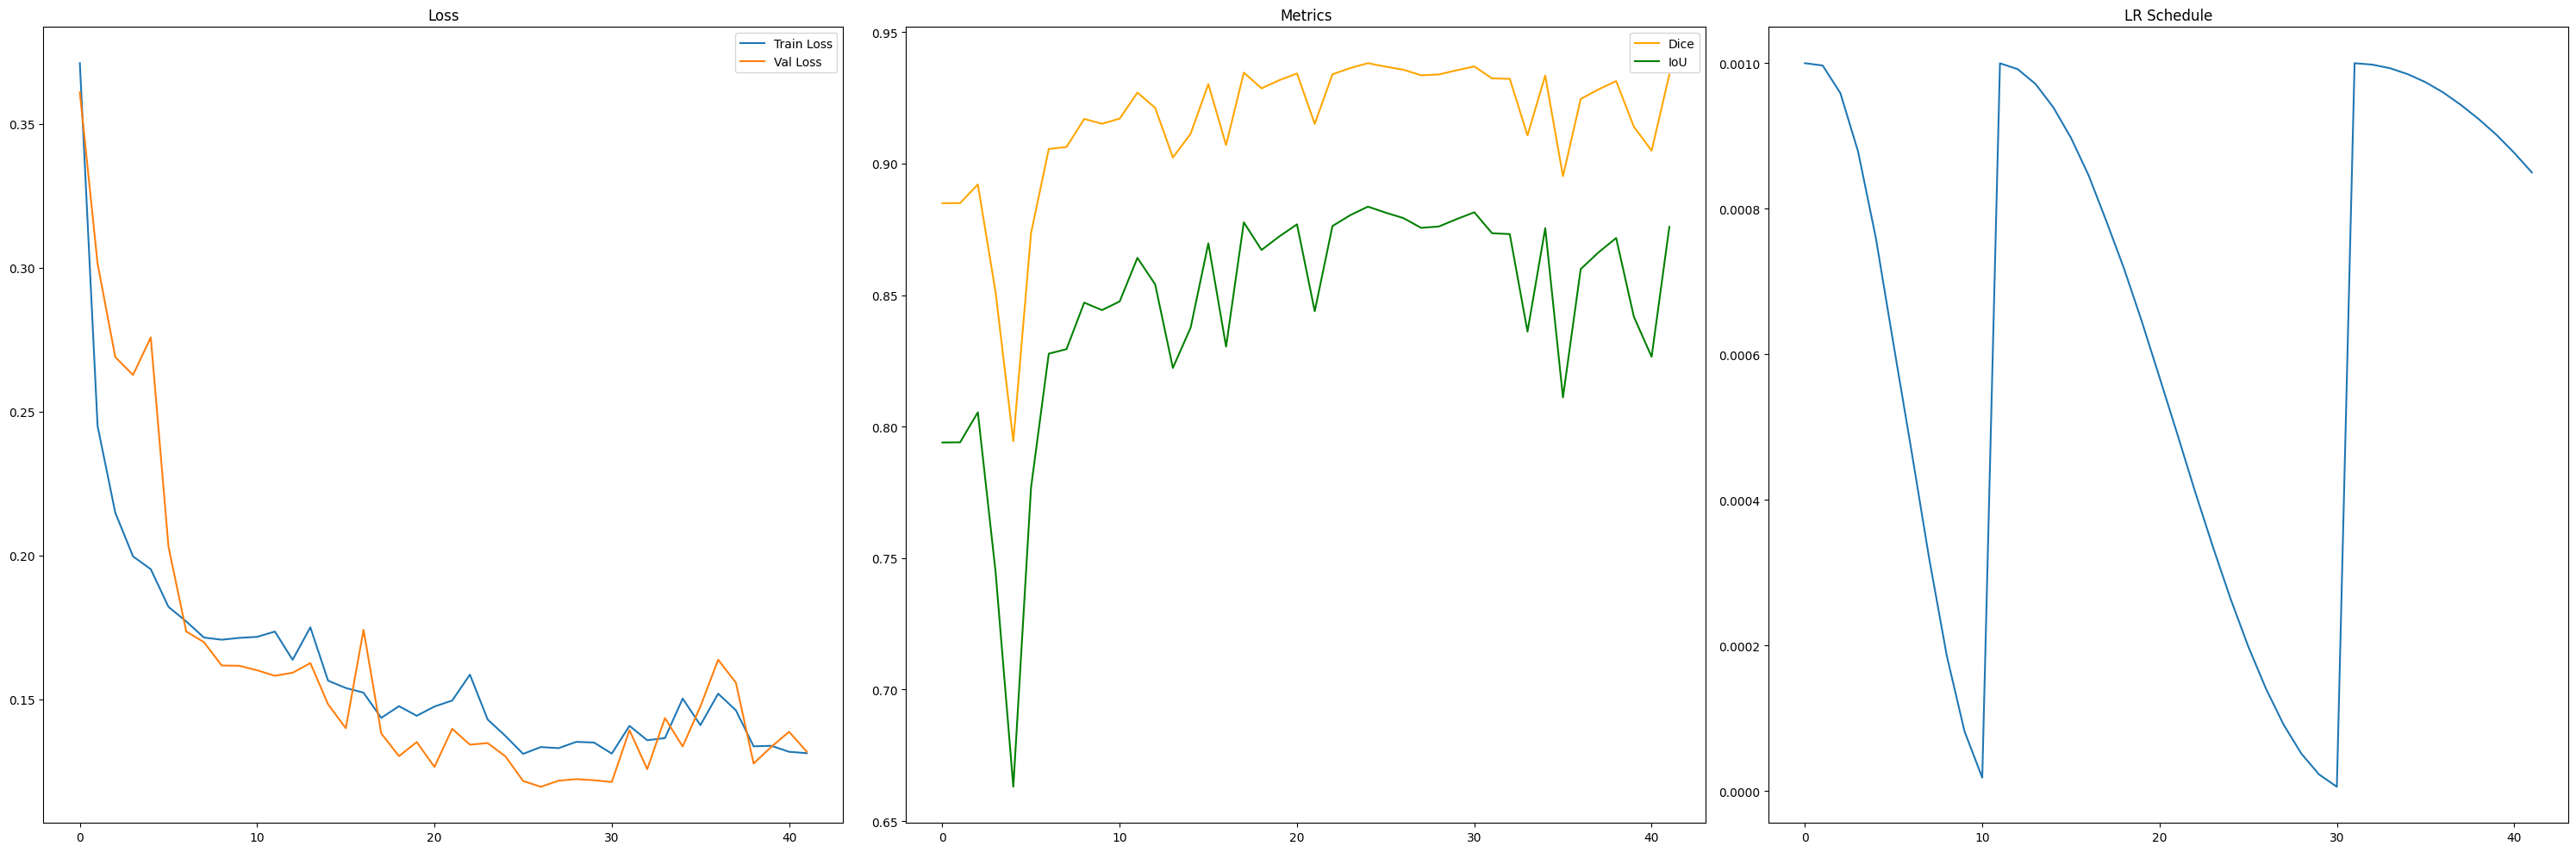

In [12]:

# 绘制曲线
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
axs[0].plot(history['train_loss'], label='Train Loss')
axs[0].plot(history['val_loss'], label='Val Loss')
axs[0].set_title('Loss')
axs[0].legend()

axs[1].plot(history['val_dice'], label='Dice', color='orange')
axs[1].plot(history['val_iou'], label='IoU', color='green')
axs[1].set_title('Metrics')
axs[1].legend()

axs[2].plot(history['lr'], label='Learning Rate')
axs[2].set_title('LR Schedule')

plt.tight_layout()
plt.show()

Best model loaded.


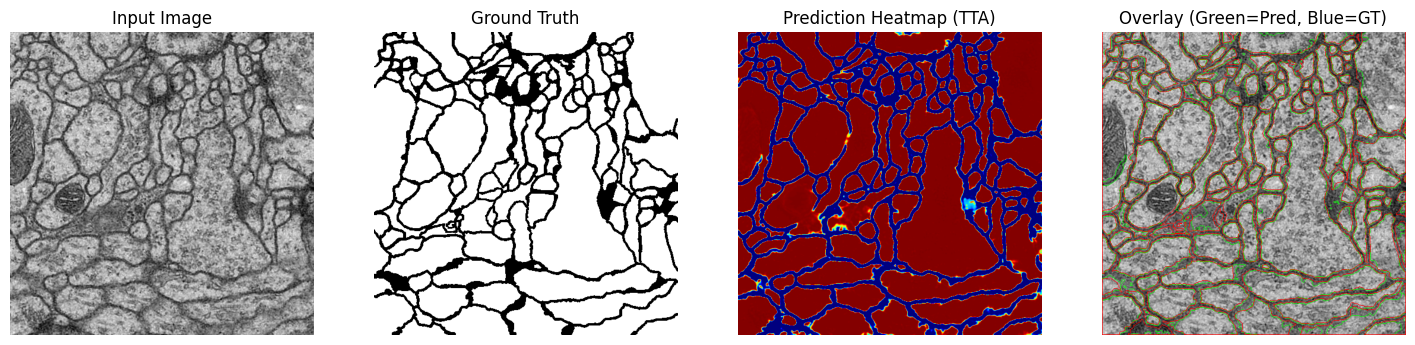

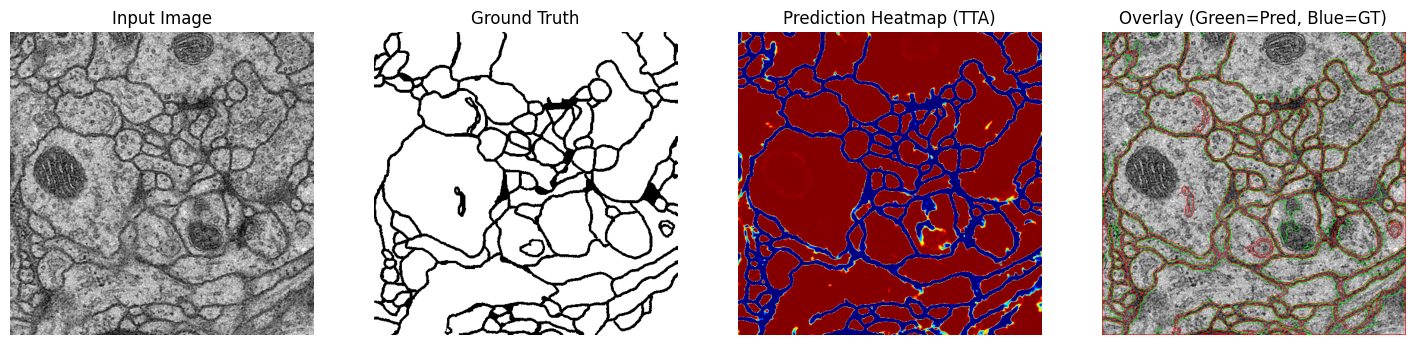

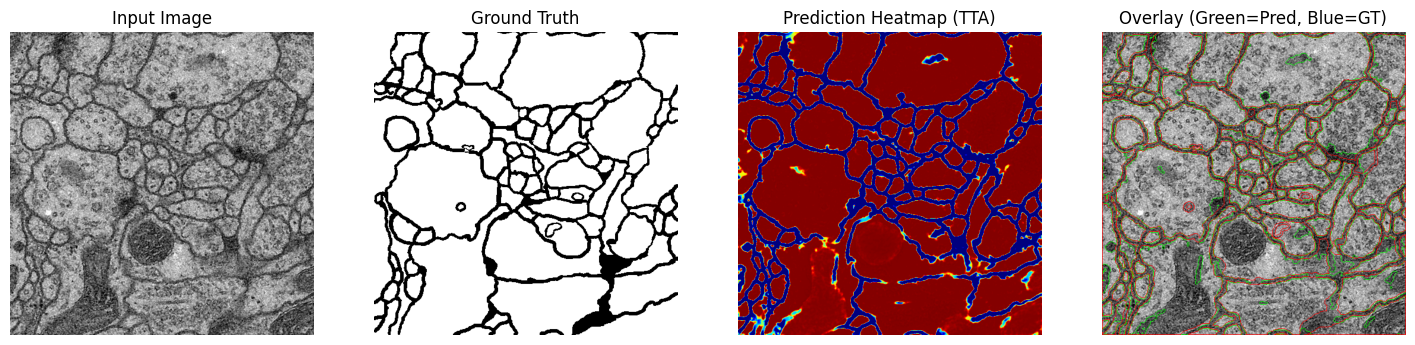

In [13]:
# --- 实现 Test Time Augmentation (TTA) ---
def predict_with_tta(model, image_tensor):
    model.eval()
    with torch.no_grad():
        # 1. 原始预测
        pred_original = F.softmax(model(image_tensor), dim=1)[:, 1, :, :]
        
        # 2. 水平翻转预测
        img_flip = torch.flip(image_tensor, [3])
        pred_flip = F.softmax(model(img_flip), dim=1)[:, 1, :, :]
        pred_flip = torch.flip(pred_flip, [2]) # 翻转回来
        
        # 3. 垂直翻转预测
        img_vflip = torch.flip(image_tensor, [2])
        pred_vflip = F.softmax(model(img_vflip), dim=1)[:, 1, :, :]
        pred_vflip = torch.flip(pred_vflip, [1])
        
        # 平均
        pred_final = (pred_original + pred_flip + pred_vflip) / 3.0
        
    return pred_final

# 加载最佳模型
model.load_state_dict(torch.load(Config.SAVE_PATH))
print("Best model loaded.")

# 在验证集上可视化 (带 TTA)
val_ds_vis = AdvancedISBIDataset(all_images[val_idx], all_labels[val_idx], augment=False)
indices_to_show = random.sample(range(len(val_ds_vis)), 3)

for idx in indices_to_show:
    img_t, mask_t = val_ds_vis[idx]
    img_gpu = img_t.unsqueeze(0).to(DEVICE)
    
    # TTA 预测
    pred_prob = predict_with_tta(model, img_gpu)
    pred_mask = (pred_prob > 0.5).float().cpu().numpy().squeeze()
    
    # 绘图
    img_np = img_t.squeeze().numpy()
    mask_np = mask_t.squeeze().numpy()
    
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 4, 1)
    plt.imshow(img_np, cmap='gray')
    plt.title("Input Image")
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(pred_prob.cpu().numpy().squeeze(), cmap='jet')
    plt.title("Prediction Heatmap (TTA)")
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    # 创建叠加图
    overlay = cv2.cvtColor((img_np*255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    contours, _ = cv2.findContours((pred_mask*255).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(overlay, contours, -1, (0, 255, 0), 1) # 绿色预测轮廓
    
    gt_contours, _ = cv2.findContours((mask_np*255).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(overlay, gt_contours, -1, (255, 0, 0), 1) # 蓝色GT轮廓
    
    plt.imshow(overlay)
    plt.title("Overlay (Green=Pred, Blue=GT)")
    plt.axis('off')
    
    plt.show()